In [48]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("input/tox24_challenge_train_all_ready.csv.gz", compression="gzip")
df

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,Standardized_SMILES,activity,MolWt,LogP
0,BrCCBr,13.4,187.862,1.7762
1,C#CC(C)(C)NC(=O)c1cc(Cl)cc(Cl)c1,64.8,256.132,3.1350
2,C#CC1(O)CCC2C3CC=C4CC(=O)CCC4C3CCC21C,15.8,298.426,3.4925
3,C#CC1(O)CCC2C3CC=C4CC(=O)CCC4C3CCC21CC,18.0,312.453,3.8826
4,C#CC1(O)CCC2C3CCc4cc(O)ccc4C3CCC21C,87.9,296.410,3.6126
...,...,...,...,...
970,c1ccc2c(c1)CCCC2,8.9,132.206,2.5654
971,c1ccc2c(c1)sc1ccccc12,15.7,184.263,4.0545
972,c1ccc2ccccc2c1,34.8,128.174,2.8398
973,c1ccc2ncccc2c1,34.3,129.162,2.2348


In [49]:
# Display basic information and first few rows of the dataset
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Standardized_SMILES  975 non-null    object 
 1   activity             975 non-null    float64
 2   MolWt                975 non-null    float64
 3   LogP                 975 non-null    float64
dtypes: float64(3), object(1)
memory usage: 30.6+ KB


(None,
                       Standardized_SMILES  activity    MolWt    LogP
 0                                  BrCCBr      13.4  187.862  1.7762
 1        C#CC(C)(C)NC(=O)c1cc(Cl)cc(Cl)c1      64.8  256.132  3.1350
 2   C#CC1(O)CCC2C3CC=C4CC(=O)CCC4C3CCC21C      15.8  298.426  3.4925
 3  C#CC1(O)CCC2C3CC=C4CC(=O)CCC4C3CCC21CC      18.0  312.453  3.8826
 4     C#CC1(O)CCC2C3CCc4cc(O)ccc4C3CCC21C      87.9  296.410  3.6126)

In [50]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)



In [51]:
df

,Standardized_SMILES,activity,MolWt,LogP,Fingerprints
0,BrCCBr,13.4,187.862,1.7762,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,C#CC(C)(C)NC(=O)c1cc(Cl)cc(Cl)c1,64.8,256.132,3.1350,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C#CC1(O)CCC2C3CC=C4CC(=O)CCC4C3CCC21C,15.8,298.426,3.4925,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,C#CC1(O)CCC2C3CC=C4CC(=O)CCC4C3CCC21CC,18.0,312.453,3.8826,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,C#CC1(O)CCC2C3CCc4cc(O)ccc4C3CCC21C,87.9,296.410,3.6126,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
970,c1ccc2c(c1)CCCC2,8.9,132.206,2.5654,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
971,c1ccc2c(c1)sc1ccccc12,15.7,184.263,4.0545,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
972,c1ccc2ccccc2c1,34.8,128.174,2.8398,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
973,c1ccc2ncccc2c1,34.3,129.162,2.2348,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [52]:
df.sort_values(by="LogP",ascending=False)

,Standardized_SMILES,activity,MolWt,LogP,Fingerprints
300,CCCCCCC(O)CC=CCCCCCCCOC(=O)OCCOCC(COCCOC(=O)OC...,-22.0,1113.606,15.7190,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
299,CCCCCCC(O)CC=CCCCCCCCC(=O)OCCN(CCOC(=O)CCCCCCC...,60.8,990.546,14.9429,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
126,CC(C)CCCCCCCOC(=O)c1ccc(C(=O)OCCCCCCCC(C)C)c(C...,43.0,630.951,11.1468,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
131,CC(C)CCCCCCOC(=O)c1ccc(C(=O)OCCCCCCC(C)C)c(C(=...,3.2,588.870,9.9765,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
275,CCCCC(CC)COC(=O)c1c(Br)c(Br)c(Br)c(Br)c1C(=O)O...,32.4,706.148,9.4830,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
789,O=C(NCNC(=O)Nc1c(O)[nH]c(=O)n1CO)Nc1c(O)[nH]c(...,20.5,388.297,-3.1223,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
770,O=C(C(=O)C(O)O)C(O)O,19.0,150.086,-3.2540,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
790,O=C(NCO)N(CO)c1c(O)n(CO)c(=O)n1CO,9.7,278.221,-3.3294,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
921,OCC1OC(OC2(CO)OC(CO)C(O)C2O)C(O)C(O)C1O,8.1,342.297,-5.3956,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [70]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import pickle


def perform_sfcv(df, k=10, sort_by="LogP", additional_info=None):
    
    # Prepare features and target
    X = np.array(list(df['Fingerprints']))
    y = df['activity'].values
    smiles = df['Standardized_SMILES'].values
    sorting_var = df[sort_by].values
    
    if sort_by is not None:
        # Sort the indices based on the sorting column
        idx = np.argsort(-df["LogP"].values) # Sort in descending values
        X, y, smiles, sorting_var = X[idx], y[idx], [smiles[i] for i in idx], [sorting_var[i] for i in idx]
    
    rmse_list=list()
    r2_list=list()
    
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        
        if sort_by is not None:
            sort_by_test = sorting_var[start:stop] 

       
        # Set up the XGBoost regressor
        model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)

        # Parameters to optimize
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }

        # Setup the GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

        # Fit the model
        grid_search.fit(X_train, y_train)

        # Best model after parameter optimization
        best_model = grid_search.best_estimator_

        best_model.fit(X_train, y_train)
        
        # Save the model to a file
        with open(f'models/model_batch_{i+1}.pkl', 'wb') as file:
            pickle.dump(best_model, file)

        y_preds = best_model.predict(X_test)

        pearson_corr, _ = stats.pearsonr(y_test, y_preds)
        rmse = np.sqrt(mean_squared_error(y_test, y_preds))
        r2 = r2_score(y_test, y_preds)
        
        rmse_list.append(rmse) 
        r2_list.append(r2)

        print(f"Pearson correlation: {pearson_corr}")
        print(f"RMSE: {rmse}")
        print(f"R²: {r2}")
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'y_true':y_test ,'y_preds':y_preds})
        discoveries.plot.scatter(x="y_true", y="y_preds")
        plt.show()
        
        smiles_train=np.concatenate([smiles[:start]])
        sort_by_train=np.concatenate([sorting_var[:start]])
        
        training_df=pd.DataFrame({
        'Standardized_SMILES': smiles_train,
        'y_true': y_train,
        'y_preds': best_model.predict(X_train),
        f'{sort_by}': sort_by_train
        })
        training_df.insert(0,'training batch',(i+1))
        
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        
        testing_df=pd.DataFrame({
        'Standardized_SMILES': smiles_test,
        'y_true': y_test,
        'y_preds': y_preds,
        f'{sort_by}': sort_by_test
        })
        testing_df.insert(0,'testing batch',(i+1))
        
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        predictions_all.extend(y_preds.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("output/logp_sorted_fcv_results_RF_training batches.csv", index=False)
    test_df.to_csv("output/logp_sorted_fcv_results_RF_testing batches.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'y_true': true_values_all,
        'y_preds': predictions_all,
        f'{sort_by}': sort_by_all
        
    })

    # Return the DataFrame for further use or analysis
    return results_df, rmse_list, r2_list

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Pearson correlation: 0.6398133989261884
RMSE: 33.00186570269525
R²: 0.3174018780896575


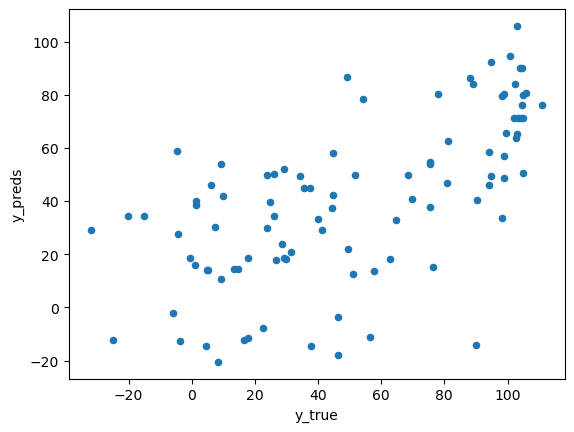

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Pearson correlation: 0.5857806906949086
RMSE: 30.064143870994343
R²: 0.28464154333386826


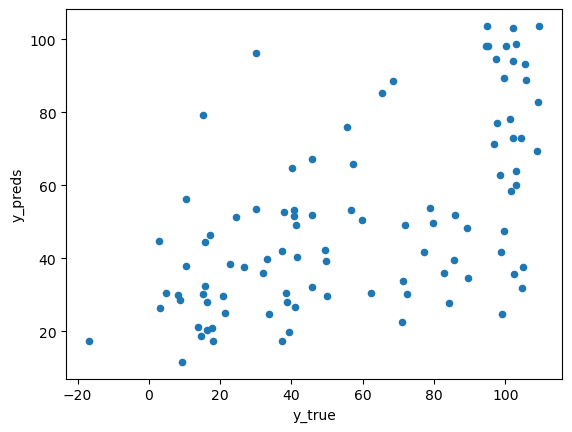

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Pearson correlation: 0.593678544281415
RMSE: 27.927496183046173
R²: 0.32996454993024615


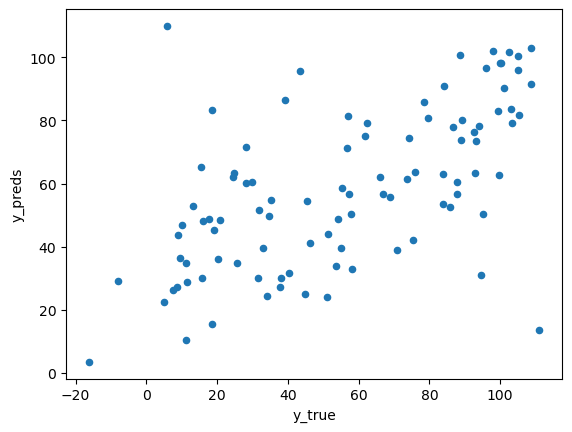

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Pearson correlation: 0.6809454190516239
RMSE: 26.72589437584711
R²: 0.44458986811233236


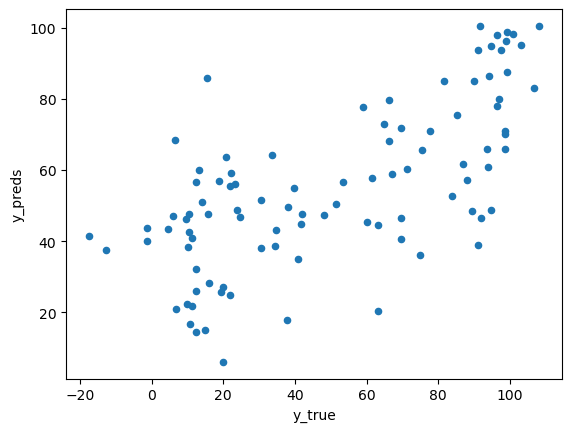

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Pearson correlation: 0.6531970466744923
RMSE: 28.51716923918444
R²: 0.3370167483213379


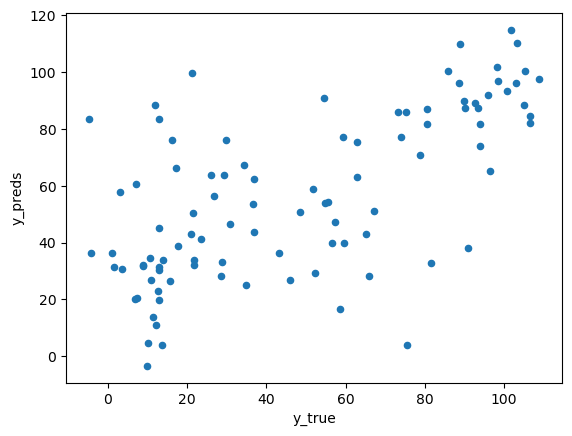

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Pearson correlation: 0.6675323761694052
RMSE: 26.246747796709336
R²: 0.21703131559173516


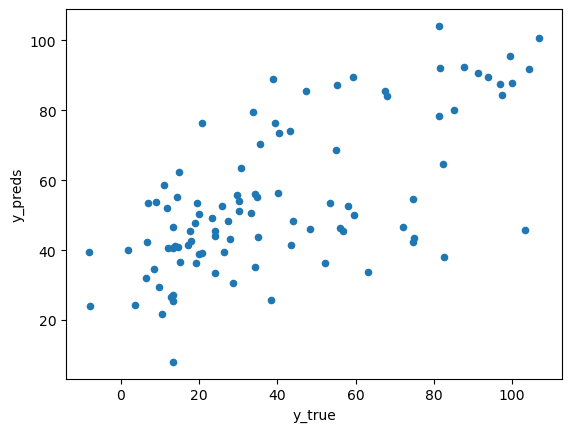

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Pearson correlation: 0.4882665685533062
RMSE: 35.72891876928138
R²: -0.334884048976972


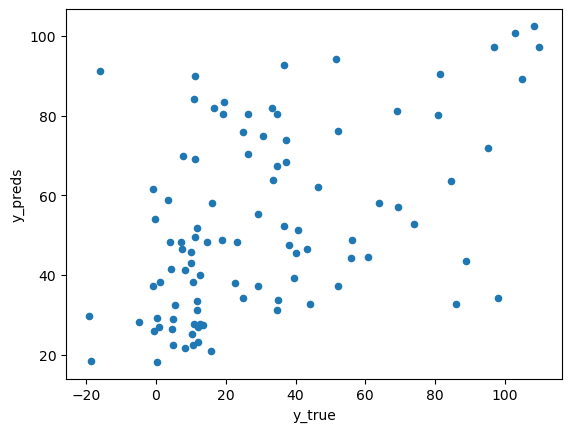

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Pearson correlation: 0.3583300421047081
RMSE: 32.66054763534947
R²: -0.3289991363257547


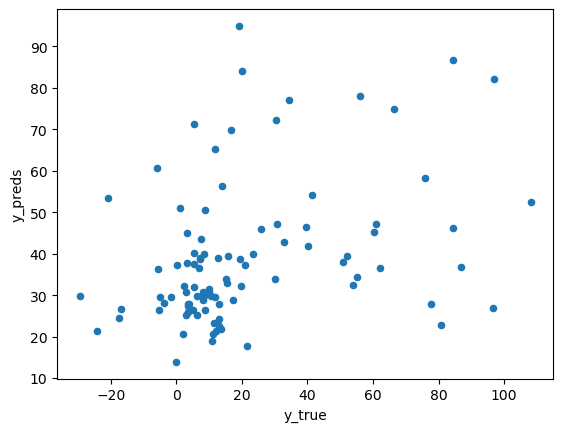

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Pearson correlation: 0.06444021774208149
RMSE: 26.335629327701085
R²: -2.498646645203244


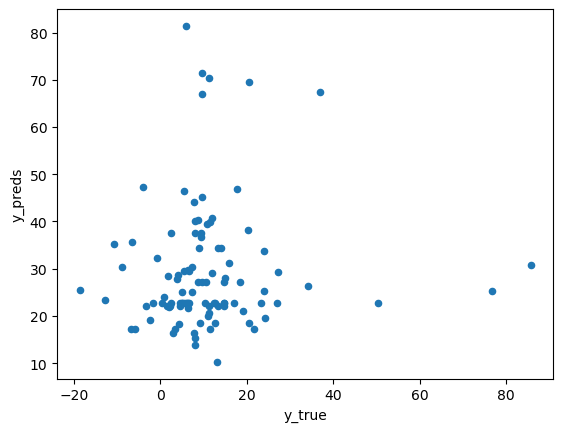

In [71]:
# Execute SFCV sorted by LogP

results_df, rmse_list, r2_list = perform_sfcv(df, sort_by="LogP")

In [72]:
results_df

,Standardized_SMILES,y_true,y_preds,LogP
0,CCCCCCCCCCCCCCCCOS(=O)(=O)O,78.0,80.444092,5.2871
1,ClC1=C(Cl)C2(Cl)C3C4C=CC(C4)C3C1(Cl)C2(Cl)Cl,-15.0,34.323654,5.2702
2,CSC(=O)c1c(C(F)F)nc(C(F)(F)F)c(C(=O)SC)c1CC(C)C,44.8,58.026981,5.2429
3,C=C(C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,9.4,53.965191,5.2346
4,O=C(O)Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(I)c1,105.0,79.763733,5.2300
...,...,...,...,...
873,O=C(NCNC(=O)Nc1c(O)[nH]c(=O)n1CO)Nc1c(O)[nH]c(...,20.5,69.525085,-3.1223
874,O=C(C(=O)C(O)O)C(O)O,19.0,21.132986,-3.2540
875,O=C(NCO)N(CO)c1c(O)n(CO)c(=O)n1CO,9.7,71.481316,-3.3294
876,OCC1OC(OC2(CO)OC(CO)C(O)C2O)C(O)C(O)C1O,8.1,40.118248,-5.3956


In [73]:
train_df = pd.read_csv("output/logp_sorted_fcv_results_RF_training batches.csv")
train_df

,training batch,Standardized_SMILES,y_true,y_preds,LogP
0,1,CCCCCCC(O)CC=CCCCCCCCOC(=O)OCCOCC(COCCOC(=O)OC...,-22.0,-9.561249,15.71900
1,1,CCCCCCC(O)CC=CCCCCCCCC(=O)OCCN(CCOC(=O)CCCCCCC...,60.8,41.953426,14.94290
2,1,CC(C)CCCCCCCOC(=O)c1ccc(C(=O)OCCCCCCCC(C)C)c(C...,43.0,14.213502,11.14680
3,1,CC(C)CCCCCCOC(=O)c1ccc(C(=O)OCCCCCCC(C)C)c(C(=...,3.2,14.213502,9.97650
4,1,CCCCC(CC)COC(=O)c1c(Br)c(Br)c(Br)c(Br)c1C(=O)O...,32.4,26.729660,9.48300
...,...,...,...,...,...
4360,9,c1c[nH]cn1,3.6,14.363874,0.40970
4361,9,CCCOCCO,3.0,22.790966,0.40530
4362,9,CC1CO1,13.7,17.136328,0.40510
4363,9,CCOCC(C)O,3.0,17.239910,0.40370


In [74]:
test_df = pd.read_csv("output/logp_sorted_fcv_results_RF_testing batches.csv")
test_df

,testing batch,Standardized_SMILES,y_true,y_preds,LogP
0,1,CCCCCCCCCCCCCCCCOS(=O)(=O)O,78.0,80.444090,5.2871
1,1,ClC1=C(Cl)C2(Cl)C3C4C=CC(C4)C3C1(Cl)C2(Cl)Cl,-15.0,34.323654,5.2702
2,1,CSC(=O)c1c(C(F)F)nc(C(F)(F)F)c(C(=O)SC)c1CC(C)C,44.8,58.026980,5.2429
3,1,C=C(C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)...,9.4,53.965190,5.2346
4,1,O=C(O)Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(I)c1,105.0,79.763730,5.2300
...,...,...,...,...,...
873,9,O=C(NCNC(=O)Nc1c(O)[nH]c(=O)n1CO)Nc1c(O)[nH]c(...,20.5,69.525085,-3.1223
874,9,O=C(C(=O)C(O)O)C(O)O,19.0,21.132986,-3.2540
875,9,O=C(NCO)N(CO)c1c(O)n(CO)c(=O)n1CO,9.7,71.481316,-3.3294
876,9,OCC1OC(OC2(CO)OC(CO)C(O)C2O)C(O)C(O)C1O,8.1,40.118248,-5.3956
